#### This file presents the example usage of the proposed solution to the problem of discriminating the antibody sequence and classifying it as human or murine.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import roc_curve, confusion_matrix
import mlflow
import dalex as dx
from NA_train import train_model
from utils import load_data, tokenize, train_val_test_split

np.random.seed(42)
tf.random.set_seed(42)

In order to solve the given problem three different neural network architectures were evaluated:
 - Multilayer perceptron (MLP) with 3 fully connected layers
 - Bidirectional GRU with one fully connected layer
 - Bidirectional LSTM with one fully connected layer

Each architecture has one neuron with a sigmoid activation function as an output, thus the output of the model is a score that indicates whether a given antibody sequence appears more human (values closer to 1) or mouse (values closer to 0).

Dataset was divided into train, validation and test sets (60/20/20).
For the purpose of hyperparameters tuning random grid search approach was used with 5 (due to limited time) different sets of parameters tested for each architecture type. 

The experiments were executed using `experiments.py` script and experiment tracking was performed using MLflow and Tensorboard.

Based on the obtained results it seems that MLP is a very promising architecture for this particular problem as it obtained perfect results for both training and validation sets for different parameter values. It is worth mentioning that one tested LSTM architecture also obtained perfect results, however training of this model was much more time consuming. That is why it was decided to present the solution with MLP architecture.

The final model was fitted with the combined training and validation datasets with the parameters that gave the best results in the shortest time.

# 1. Model training
The model for the given problem might be fitted from scratch or an existing model can be loaded.

In [ ]:
# model = train_model(
#     model_type='MLP', 
#     embedding_dim=16, 
#     dense_neurons=100, 
#     epochs=4, 
#     batch_size=512, 
#     learning_rate=0.0001, 
#     test=True, 
#     run_name='MLP_Test'
#     )
model = mlflow.keras.load_model('./mlruns/0/3919dbd70086486fba1bb20e59bff56f/artifacts/model_MLP_Test')

# 2. Model evaluation

In [ ]:
! mlflow ui

In [3]:
! tensorboard --logdir logs/fit

## 2.1. Out of sample prediction

In [4]:
# Loading and preparing the data
df = load_data()
tokenizer, df_t = tokenize(df)
words_number = len(tokenizer.word_index)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_t)

In [ ]:
# Predicting labels for the test set
y_hat_test = model.predict(X_test)
y_pred_test = np.round(y_hat_test)

## 2.2. Results visualization

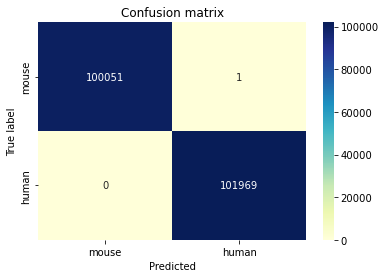

In [6]:
# Ploting confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="YlGnBu")
plt.xticks([0.5,1.5],['mouse', 'human'])
plt.yticks([0.5,1.5],['mouse', 'human'])
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()


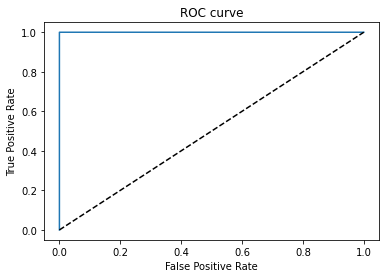

In [7]:
# Plorring ROC curve
fpr, tpr, _ = roc_curve(y_test,  y_hat_test)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--k')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.show()

# 3. XAI
In order to better understand the model and its behavoiur Dalex package for explainable AI techniques was used.

In [ ]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Uncomment the below line if the model was fitted from scratch
# model = model.model 

explainer_train_val = dx.Explainer(model, X_train_val, y_train_val, label='label',verbose=False)
explainer_test = dx.Explainer(model, X_test, y_test, label='label',verbose=False)
print('Explainers created')
vi_train_val = explainer_train_val.model_parts(N=5000, B=15)
print('After model_parts for train_val')
vi_test = explainer_test.model_parts(N=5000, B=15)
print('After model_parts for train_val')

In [12]:
# Plotting top 10 most important variables for the training and validation sets 
vi_train_val.plot(max_vars=15)

/Users/mrosol/miniforge3/envs/tf-mac/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [13]:
# Plotting top 10 most important variables for the test set
vi_test.plot(max_vars=15)

/Users/mrosol/miniforge3/envs/tf-mac/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



Over half of the 10% of most important variables are the same in the case of test and training datasets with similar variable importance values, which indicates that the model is not overfitting.